### Grain Dataset Loading & EDA

This notebook provides quick utilities to:
- Load `.npz` files from `Grain-Data` (hyperspectral) and `Grain-Data-RGB` (RGB)
- Summarize directory stats (counts, sizes)
- Inspect and compare array keys/shapes/dtypes
- Sample and plot label distributions
- Visualize a sample RGB image and a hyperspectral false-color composite
- Plot mean spectral profile for a hyperspectral sample

In [3]:
# Imports
import os, zipfile, struct, ast, random
import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas as pd
except Exception:
    pd = None

# Plot config
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

In [4]:
# Paths
GRAIN_DATA = "/home/moujar/dev/Grain-Challenge-M1-AI/data/Grain-Data"
GRAIN_DATA_RGB = "/home/moujar/dev/Grain-Challenge-M1-AI/data/Grain-Data-RGB"

for p in (GRAIN_DATA, GRAIN_DATA_RGB):
    assert os.path.isdir(p), f"Missing directory: {p}"


def list_npz_files(folder: str, limit: int | None = None) -> list[str]:
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npz')]
    files.sort()
    return files[:limit] if limit else files

print("Samples:")
print("Grain-Data →", os.path.basename(list_npz_files(GRAIN_DATA, 1)[0]))
print("Grain-Data-RGB →", os.path.basename(list_npz_files(GRAIN_DATA_RGB, 1)[0]))

Samples:
Grain-Data → grain10002_x42y22-var4_11000_us_2x_2020-12-02T113138_corr.npz
Grain-Data-RGB → grain10000_x42y22-var4_11000_us_2x_2020-12-02T113138_corr.npz


In [5]:
# Utilities: read .npy header from inside .npz without full load

def _npy_header_info(fobj) -> dict:
    magic = fobj.read(6)
    if magic != b"\x93NUMPY":
        return {"error": "not npy"}
    major = fobj.read(1)[0]
    minor = fobj.read(1)[0]
    if major == 1:
        import struct as _st
        hlen = _st.unpack("<H", fobj.read(2))[0]
    elif major in (2, 3):
        import struct as _st
        hlen = _st.unpack("<I", fobj.read(4))[0]
    else:
        return {"error": f"unknown npy version {major}.{minor}"}
    header = fobj.read(hlen)
    import ast as _ast
    try:
        return _ast.literal_eval(header.decode('latin1'))
    except Exception as e:
        return {"error": f"header parse error: {e}", "raw": header[:120]}


def inspect_npz_header(npz_path: str) -> list[dict]:
    """Return list of array header infos (name, shape, dtype)."""
    infos: list[dict] = []
    with zipfile.ZipFile(npz_path, 'r') as zf:
        for name in zf.namelist():
            if not name.endswith('.npy'):
                continue
            with zf.open(name) as npy:
                h = _npy_header_info(npy)
            infos.append({
                "name": name[:-4],
                "shape": h.get('shape'),
                "dtype": h.get('descr'),
                "fortran_order": h.get('fortran_order'),
                "error": h.get('error')
            })
    return infos


def load_rgb_npz(npz_path: str):
    with np.load(npz_path, allow_pickle=False) as data:
        x = data['x']
        y = data['y']
        label = y.tolist() if y.shape == () else str(y)
        meta = {}
        if 'original_filename' in data:
            meta['original_filename'] = data['original_filename'].tolist()
        if 'bands' in data:
            meta['bands'] = data['bands'].tolist()
    return x, label, meta


def load_hsi_npz(npz_path: str):
    with np.load(npz_path, allow_pickle=False, mmap_mode='r') as data:
        X = data['X']  # shape (H, W, B)
        y = data['y']
        label = y.tolist() if y.shape == () else str(y)
    return X, label


def dir_stats(folder: str) -> dict:
    sizes = []
    count = 0
    for e in os.scandir(folder):
        if e.is_file() and e.name.endswith('.npz'):
            count += 1
            sizes.append(e.stat().st_size)
    total = int(sum(sizes))
    avg = float(total / count) if count else 0.0
    return {"count": count, "total_bytes": total, "avg_bytes": avg}


def bytes_to_human(n: int) -> str:
    step = 1024.0
    units = ['B','KB','MB','GB','TB']
    val = float(n)
    for u in units:
        if val < step:
            return f"{val:.2f} {u}"
        val /= step
    return f"{val*step:.2f} TB"

In [7]:
# Directory stats
stats_rgb = dir_stats(GRAIN_DATA_RGB)
stats_hsi = dir_stats(GRAIN_DATA)

summary_rows = [
    {"dataset": "Grain-Data-RGB", **stats_rgb},
    {"dataset": "Grain-Data (HSI)", **stats_hsi},
]

if pd is not None:
    df = pd.DataFrame(summary_rows)
    df['total'] = df['total_bytes'].map(bytes_to_human)
    df['avg'] = df['avg_bytes'].map(bytes_to_human)
    display(df[['dataset','count','total','avg']])
else:
    for r in summary_rows:
        print(r['dataset'], r['count'], bytes_to_human(r['total_bytes']), bytes_to_human(r['avg_bytes']))

# Inspect one file header from each directory
sample_rgb = list_npz_files(GRAIN_DATA_RGB, 1)[0]
sample_hsi = list_npz_files(GRAIN_DATA, 1)[0]
print("\nSample RGB header keys/shapes:")
for info in inspect_npz_header(sample_rgb):
    print(info)
print("\nSample HSI header keys/shapes:")
for info in inspect_npz_header(sample_hsi):
    print(info)

Grain-Data-RGB 26882 1.12 GB 43.76 KB
Grain-Data (HSI) 2400 61.32 GB 26.16 MB

Sample RGB header keys/shapes:
{'name': 'x', 'shape': (252, 252, 3), 'dtype': '<i2', 'fortran_order': False, 'error': None}
{'name': 'y', 'shape': (), 'dtype': '<U1', 'fortran_order': False, 'error': None}
{'name': 'original_filename', 'shape': (), 'dtype': '<U61', 'fortran_order': False, 'error': None}
{'name': 'bands', 'shape': (3,), 'dtype': '<i8', 'fortran_order': False, 'error': None}

Sample HSI header keys/shapes:
{'name': 'X', 'shape': (252, 252, 216), 'dtype': '<i2', 'fortran_order': False, 'error': None}
{'name': 'y', 'shape': (), 'dtype': '<U1', 'fortran_order': False, 'error': None}


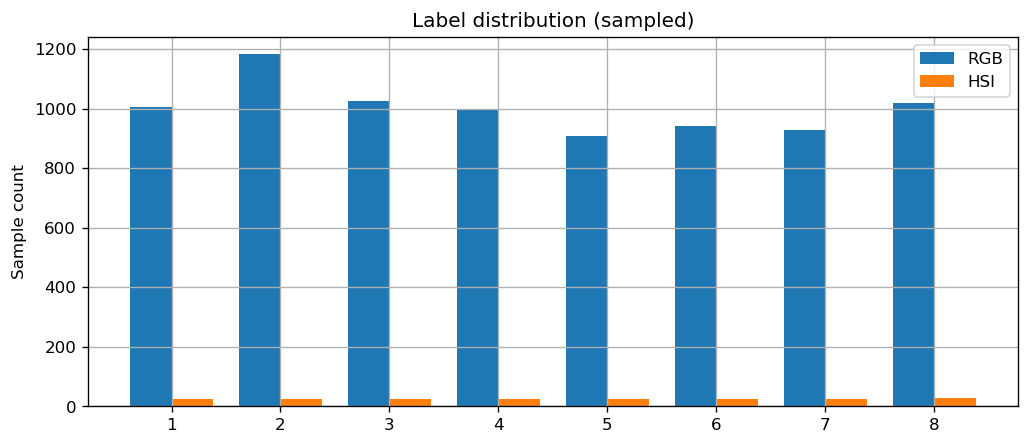

In [8]:
# Label sampling & distribution

def read_label(npz_path: str) -> str:
    with np.load(npz_path, allow_pickle=False) as data:
        y = data['y']
        return str(y.tolist() if y.shape == () else y)


def sample_label_counts(folder: str, max_files: int = 2000) -> dict[str,int]:
    files = list_npz_files(folder)
    if not files:
        return {}
    if len(files) > max_files:
        rng = np.random.default_rng(42)
        idx = rng.choice(len(files), size=max_files, replace=False)
        files = [files[i] for i in idx]
    counts: dict[str,int] = {}
    for f in files:
        try:
            lbl = read_label(f)
        except Exception:
            lbl = "__ERR__"
        counts[lbl] = counts.get(lbl, 0) + 1
    return counts

counts_rgb = sample_label_counts(GRAIN_DATA_RGB, max_files=8000)
counts_hsi = sample_label_counts(GRAIN_DATA, max_files=200)

# Merge & plot
labels = sorted(set(counts_rgb) | set(counts_hsi))
rgb_vals = [counts_rgb.get(k, 0) for k in labels]
hsi_vals = [counts_hsi.get(k, 0) for k in labels]

x = np.arange(len(labels))
width = 0.38
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x - width/2, rgb_vals, width, label='RGB')
ax.bar(x + width/2, hsi_vals, width, label='HSI')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel('Sample count')
ax.set_title('Label distribution (sampled)')
ax.legend()
plt.show()

# Show raw counts if pandas is present
if pd is not None:
    dfc = pd.DataFrame({
        'label': labels,
        'RGB': rgb_vals,
        'HSI': hsi_vals,
    })
    display(dfc)

In [10]:
# Visualization helpers

def percentile_stretch(img: np.ndarray, p_lo: float = 2.0, p_hi: float = 98.0) -> np.ndarray:
    lo = np.percentile(img, p_lo)
    hi = np.percentile(img, p_hi)
    if hi <= lo:
        hi = lo + 1.0
    out = (img.astype(np.float32) - lo) / (hi - lo)
    return np.clip(out, 0.0, 1.0)


def show_rgb_sample(npz_path: str):
    x, label, meta = load_rgb_npz(npz_path)
    disp = percentile_stretch(x)
    fig, ax = plt.subplots(1, 1, figsize=(4.2, 4.2))
    ax.imshow(disp)
    ax.set_title(f"RGB label={label}\n{os.path.basename(npz_path)}")
    ax.axis('off')
    if meta:
        print("meta:", meta)


def show_hsi_sample(npz_path: str, band_indices: tuple[int,int,int] = (20, 60, 100)):
    X, label = load_hsi_npz(npz_path)
    H, W, B = X.shape
    bi = tuple(int(max(0, min(B-1, i))) for i in band_indices)
    rgb = np.stack([X[:,:,bi[0]], X[:,:,bi[1]], X[:,:,bi[2]]], axis=-1)
    disp = percentile_stretch(rgb)
    mean_spectrum = X.mean(axis=(0, 1))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(disp)
    axes[0].set_title(f"HSI false color (bands {bi})\nlabel={label}")
    axes[0].axis('off')

    axes[1].plot(mean_spectrum)
    axes[1].set_title("Mean spectral profile (image)")
    axes[1].set_xlabel("Band index")
    axes[1].set_ylabel("Intensity (int16)")
    plt.tight_layout()

# Pick and display samples
rgb_files = list_npz_files(GRAIN_DATA_RGB)
hsi_files = list_npz_files(GRAIN_DATA)

if rgb_files:
    show_rgb_sample(random.choice(rgb_files))
if hsi_files:
    show_hsi_sample(random.choice(hsi_files))

meta: {'original_filename': 'grain22114_var6-x79y13_7000_us_2x_2021-10-19T153133_corr.npz', 'bands': [22, 53, 89]}
